Nozomu Nakanishi - 2020264 - Msc DA

This notebook presents the technical part of the research which aims to develop a neural network for sentiment analysis using LSTM.
The chronological order will follow: 
- Introduction;
- Data preparation and EDA; 
- Text pre-processing;
- Padding and Word2Vec;
- Notes; 
- LSTM; 

## 1. Introduction 

The experiment will be carried out by importing the chosen dataset from Kaggle, the data is licensed under the Creative Commons (CC0 1.0 DEED), allowing the use of the data. 

The link for the dataset is available at kaggle: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

The objective of the notebook is to develop a neural network using PySpark (chosen tool for the project) and the chosen dataset to achieve the goal is the recipe reviews from food.com, which is  composed by 8 features and more tham a million rows.
- There are two datasets in the zip file, however it does not says that the recipe ID in one will match the recipe ID in the other, therefore using only the reviews dataset.
- Also, two types of format is available, parquet and csv files. And the choice for the first one is that the parquet file already has a columnar type, which when taking into consideration the tools that are being used such as pyspark it will present a better speed perfomance when performing tasks. In addition to the reduction for its size in megabytes (csv - 496.1 and 173.8). 
- The dataset review, which is going to be manipulated, is about the written reviews along with score rating given. They are the most important features in the dataset to achieve the objective. 

The practical part of the task will be carried out by performing sentiment analysis using Long Short Term Memory (LSTM).

In [1]:
# The command below is to check where the PySpark is running, 
# in this case (returned:local[*]) data is being processed on my local (personal) machine.

sc.master

'local[*]'

- The libraries to perform the required stages are going to be imported in the next cell.

In [2]:
from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import lower # lower case function.
from pyspark.sql.functions import length # Import lenght function.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.functions import explode, desc # Importing for word count.
from pyspark.ml.feature import StopWordsRemover # Imports stopword remover.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.types import FloatType # FloatType (data)
from pyspark.sql.functions import udf # Imports function UDF (user defined functions).
from pyspark.sql.functions import pandas_udf # user defined functions
from pyspark.ml.feature import StringIndexer, OneHotEncoder # enconde labels
from pyspark.ml import Pipeline # Creates a pipeline for the encoder
from pyspark.sql.types import ArrayType # Array types of data
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import max as max_
from tensorflow.keras.preprocessing.sequence import pad_sequences
import spacy # Lemmatization tool
import numpy as np # for numerical operations.
import seaborn as sns # Visualization tool.
import matplotlib.pyplot as plt # visualization
%matplotlib inline 

import warnings # Ignore warnings.
warnings.filterwarnings("ignore")

2023-10-11 19:52:40.448974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 19:52:42.198588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-11 19:52:42.198654: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-11 19:52:42.553200: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 19:52:45.557730: W tensorflow/stream_executor/platform/defaul

In [3]:
# Initiating spark session.
spark = SparkSession.builder.appName('recipe_reviews').getOrCreate()

## 2. Data preparation and EDA
- Challeging to separete them both because it will be performed back and forth.
- First, the numerical feature will be analysed and after the written review. 

#### - Importing the Review dataset.

To start the dataset will be imported in parquet format as cited in the introduction.

In [4]:
# Imports the dataset in a parquet format.
df_reviews = spark.read.parquet("file:///home/hduser/Downloads/Dataset CA1/reviews.parquet")

In [5]:
# Prints the Schema of the dataset.
df_reviews.printSchema()

root
 |-- ReviewId: integer (nullable = true)
 |-- RecipeId: integer (nullable = true)
 |-- AuthorId: integer (nullable = true)
 |-- AuthorName: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Review: string (nullable = true)
 |-- DateSubmitted: timestamp (nullable = true)
 |-- DateModified: timestamp (nullable = true)



- The parquet format file already had a schema, therefore keeping the original dataset schema. However, if the csv were to be handled the following code would be appropriate to apply the schema, including the column names along with the data type.

In [6]:
# Code that would be used to apply the schema in the review dataset if was required.

#schema_reviews = StructType([
    #StructField('ReviewId', IntegerType(), True),
    #StructField('RecipeId', IntegerType(), True),
    #StructField('AuthorId', IntegerType(), True),
    #StructField('AuthorName', StringType(), True),
    #StructField('Rating', IntegerType(), True),
    #StructField('Review', StringType(), True),
    #StructField('DateSubmitted', TimestampType(), True),
    #StructField('DateModified', TimestampType(), True)])

The library Pandas used in the previous semester had different set of functions and/or commands. For example, the shape which provided the number of columns and observations in the dataset. However, in the PySpark the count method is use to tell how many rows and the lenght of the columns for the number of features. 
<br>However, in a later stage pandas format will be used for visualization purpose only, because pandas visualizations are better than the pyspark.

In [7]:
# It shows the first ten observations.
df_reviews.show(10)

+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|ReviewId|RecipeId|AuthorId|      AuthorName|Rating|              Review|      DateSubmitted|       DateModified|
+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|       2|     992|    2008|       gayg msft|     5|better than any y...|2000-01-25 21:44:00|2000-01-25 21:44:00|
|       7|    4384|    1634|   Bill Hilbrich|     4|I cut back on the...|2001-10-17 17:49:59|2001-10-17 17:49:59|
|       9|    4523|    2046|Gay Gilmore ckpt|     2|i think i did som...|2000-02-25 09:00:00|2000-02-25 09:00:00|
|      13|    7435|    1773|   Malarkey Test|     5|easily the best i...|2000-03-13 21:15:00|2000-03-13 21:15:00|
|      14|      44|    2085|      Tony Small|     5|  An excellent dish.|2000-03-28 13:51:00|2000-03-28 13:51:00|
|      17|    5221|    2046|Gay Gilmore ckpt|     4|love it, but with...|2000-05-08 12:0

In [8]:
num_rows_reviews = df_reviews.count() # Counting the number of rows.
num_columns_reviews =len(df_reviews.columns) # Length of columns.
print(f"Shape: ({num_rows_reviews}, {num_columns_reviews})") # Prints the shape of the dataset.

Shape: (1401982, 8)


The previous code shows the shape of the dataset (1401982 rows, 8 columns) and by looking at the features, a few of them will not be needed to the analysis.
- Temporal analysis is not the focus of the project, therefore, the date submitted and modified will be dropped in an early stage.
- The Ids will not be part of the model, but will remain to check if they can indicate any anomaly.  


<b>Note: Multiple columns are also being deleted after ran out of memory even when reduced 10% of the dataset.

In [9]:
# Droping two columns of the dataset.
df_reviews = df_reviews.drop("DateSubmitted", "DateModified", "RecipeId", "AuthorId", "ReviewId", "AuthorName")

In [10]:
# The two codes below are searching and printing the number of missing values in Review, Rating, Recipe Id.

missing_review = df_reviews.filter(df_reviews.Review.isNull())
print(f"Number of observations with missing Review: {missing_review.count()}")

missing_rating = df_reviews.filter(df_reviews.Rating.isNull())
print(f"Number of observations with missing Rating: {missing_rating.count()}")

Number of observations with missing Review: 0
Number of observations with missing Rating: 0


- No missing values are recorded in Review and Ratings. Only performing the command for two features because they are going to be the focus of the analysis. 

In [11]:
# Checking the scores given.
df_reviews.groupBy("Rating").count().orderBy("Rating").show()
print(f"Frequency of Ratings")


+------+-------+
|Rating|  count|
+------+-------+
|     0|  76248|
|     1|  16559|
|     2|  17597|
|     3|  50279|
|     4| 229217|
|     5|1012082|
+------+-------+

Frequency of Ratings


- The Rating columns shows that most of its values are located between 4 and 5.

The first attempt was with the entire dataset (1401982 observations), however due to computational it was attempted many times with different sample size of the original, 100%, 70%, 50%, 20%, but erros related to "out of memory", notebook crashes kept happening, thus 10% of the dataset will be handled.
- During the attempts typos in the parameters were taking hours to restart, or to wait for the error so it can be fixed later.
 
- The sampling will occur based on the labels, which will be generated in the following cell. 

In [12]:
# Creates a new column 'label' based on rating values
df_reviews = df_reviews.withColumn("label", 
                   when(col("rating").isin([0, 1, 2]), "negative")
                   .when(col("rating") == 3, "neutral")
                   .otherwise("positive")
                  )

# You can verify by showing a few records
df_reviews.select("rating", "label").show()

+------+--------+
|rating|   label|
+------+--------+
|     5|positive|
|     4|positive|
|     2|negative|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     0|negative|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     5|positive|
|     1|negative|
|     5|positive|
|     4|positive|
|     1|negative|
|     5|positive|
|     5|positive|
|     3| neutral|
+------+--------+
only showing top 20 rows



In [13]:
# Calculating the distribution of scores and the three different classes fo the train set.
# Placing the 0,1,2 to the negatives, 3 neutral and 4,5 positives.
class_counts = (
    df_reviews.withColumn(
    "Rating_class",
    when((df_reviews['Rating'] >= 0) & (df_reviews['Rating'] <= 2), "Negatives (0-2)")
    .when(df_reviews['Rating'] == 3, "Neutral (3)")
    .otherwise("Positives (4-5)"))
# Grouping the ratings into its class and using rdd to transform them into a dictionary which is easier to access in a query.
    .groupBy("Rating_class")
    .count()
    .rdd.collectAsMap())

# Calculates to total number of reviews.
total_reviews = sum(class_counts.values())
# Calculates the ratio.
Ratios = {k: v / total_reviews for k, v in class_counts.items()}
# Prints the percentages.
for Rating_class, ratio in Ratios.items():
    print(f"Rating Class {Rating_class}: {ratio*100:2f}%")

Rating Class Neutral (3): 3.586280%
Rating Class Negatives (0-2): 7.874851%
Rating Class Positives (4-5): 88.538869%


- A stratified split will be aplied to maintain the original ratio, but also not taking the risk of the sample having zero neutrals.
- The sentiment label (classes) will be used to applied the split.

In [14]:
# Calculates the fraction for each label to reduce the dataset by half
# As mentioned previously the reduction is 50%.
fraction = 0.01
reduce_fractions = {label: fraction for label in df_reviews.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Reducing the dataset by half
df_reviews = df_reviews.sampleBy("label", fractions=reduce_fractions, seed=42)


In [15]:
# Calculating the distribution of scores and the three different classes fo the train set.
# Placing the 0,1,2 to the negatives, 3 neutral and 4,5 positives.
class_counts = (
    df_reviews.withColumn(
    "Rating_class",
    when((df_reviews['Rating'] >= 0) & (df_reviews['Rating'] <= 2), "Negatives (0-2)")
    .when(df_reviews['Rating'] == 3, "Neutral (3)")
    .otherwise("Positives (4-5)"))
# Grouping the ratings into its class and using rdd to transform them into a dictionary which is easier to access in a query.
    .groupBy("Rating_class")
    .count()
    .rdd.collectAsMap())

# Calculates to total number of reviews.
total_reviews = sum(class_counts.values())
# Calculates the ratio.
Ratios = {k: v / total_reviews for k, v in class_counts.items()}
# Prints the percentages.
for Rating_class, ratio in Ratios.items():
    print(f"Rating Class {Rating_class}: {ratio*100:2f}%")

Rating Class Neutral (3): 3.449495%
Rating Class Negatives (0-2): 7.973422%
Rating Class Positives (4-5): 88.577083%


- After applying the stratfied split, the results were successful, the difference between before and after are less than decimals.

Thus, for the analysis the dataset to be handle is the 10% of the original named df_reviews.

In [16]:
# Displaying statistical features of the Reviews dataset.
df_reviews.describe().select("summary", "Rating").show()

+-------+-----------------+
|summary|           Rating|
+-------+-----------------+
|  count|            14147|
|   mean|4.406729341909945|
| stddev|1.268039054219669|
|    min|                0|
|    max|                5|
+-------+-----------------+



In [17]:
df_reviews.groupBy("Rating").count().orderBy("Rating").show()
print(f"Frequency of Ratings")

+------+-----+
|Rating|count|
+------+-----+
|     0|  751|
|     1|  179|
|     2|  198|
|     3|  488|
|     4| 2352|
|     5|10179|
+------+-----+

Frequency of Ratings


Based on statistical feature:
- The total reviews are 140529;
- It has a range of scores between 0 and 5;
- The mean of 4.4 is close to 5, therefore most of the data points are close the highest value, so the data present signs of being left-skewed (strong evidence for skewness);
- Also, because most of the values a concentrated in the score 5, the box (boxplot) might be very close or at the top at the upper whisker.
- It presents a high standard deviation given the range of the scores.
- The score zero represents the majority in the negative class, while in the positive side the maximum value is more frequent also represents more than 50% of the data.

Further analysis will be performed using visual tools.

### Ratings feature visual representation.

- The visualization tools using Pandas provided a better result, therefore for visualization (boxplot and histogram) purpose it will be created a dataframe using pandas library.

In [18]:
# Creating a dataframe using pandas library.
ratings_column_pd = df_reviews.select("Rating").toPandas()

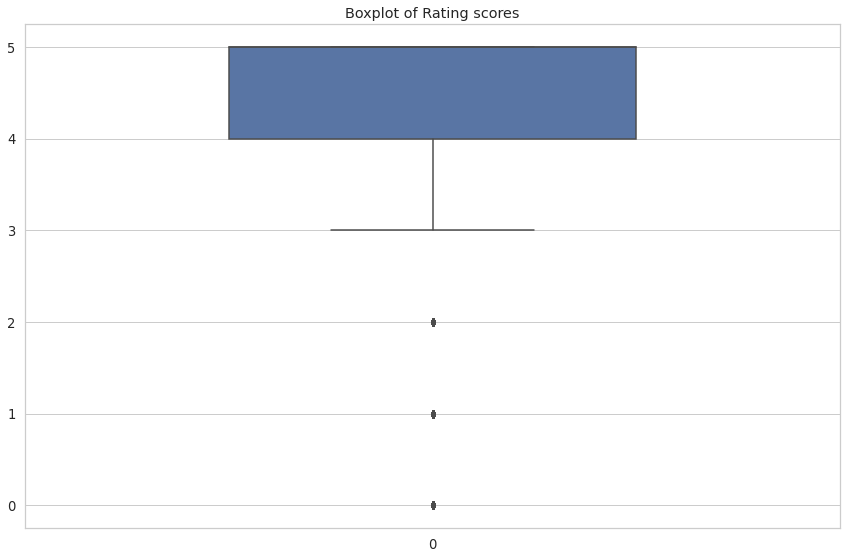

In [19]:
# Generating the figure.
plt.figure(figsize=(12, 8)) # Setting the figure size.
sns.set(style="whitegrid", font_scale=1.2) # Addind a white space on the back and adjustive font scale.
# Creates the boxplot
ax = sns.boxplot(data=ratings_column_pd['Rating'], width=0.5) # Boxplot, setting the width of the box to .5.
ax.set_title('Boxplot of Rating scores') # Add title to the figure.
plt.tight_layout() # Adjusts the layout
plt.show() # Shows the plot

The boxplot shows shows that most of values are located in the maximum values, but also points the score 0, 1 and 2 as outliers, this could be due to the fact that those values represents a small percentage of the total (approximately 7-8%). So based on IQR calculations are considering them as outliers.

- The values 1 and 2 will not be outliers, despite being a small amount they represent negative score reviews of the recipe;
- The value of 0 will be analysed in a later stage along with the writen review.

Despite considering of 1 and 2 score rating outliers, they will remain in the dataset. This is because they are still a valid data point and very important to achieve the goal. Although, the score zeros will be further analysed.

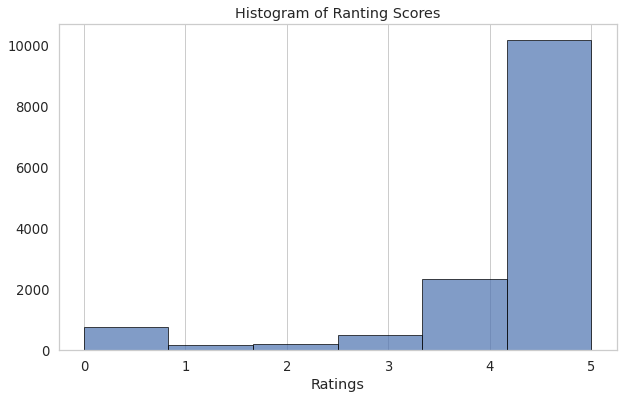

In [20]:
# Creating the figure for the histogram.
plt.figure(figsize=(10, 6))
# Plots the histogram, bins set at 6 because of the range of the value.
plt.hist(ratings_column_pd['Rating'], bins=6, edgecolor='black', alpha=0.7)
plt.title("Histogram of Ranting Scores") # Sets title.
plt.xlabel("Ratings") # Sets x label.
plt.xticks(range(6)) # Add ticks with range between 0 and 6.
plt.grid(axis='y') 
plt.show() # Display the histogram.

An extra visualization to look at the distribution of the data, the histogram shows that the ratings scores data is highly skewed to the left and most of its values are located at the maximum score.

The scores zero raised doubts about its reliability, potentially someone forgot to leave a score or if it is actually the worst score. Also, there are no notes about the score zero, so a manual check will be applied to check if there is a balance between the review and the score zero. The procedure will be done by looking at random samples (attempted multiple times with differend seed values), checking if the reviews truly represents a sentiment of a lowest score possible.

In [21]:
zero_reviews = df_reviews.filter(col("Rating") == 0)
sample_reviews = zero_reviews # Also used numerous seeds.
sample_reviews.select("Review").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review                                                                                                                                                                                                                                                                 

- According to last code (with many attempts using different seed numbers), the written reviews does not match the score zero given. Positives reviews such as, great recipe, its delicious . Therefore, the chosen option is to drop the 0 scores (anomalies), so it does not affects the analysis by introducing noise to it, increasing the consistency in the data.
- And since they are anomalies in the data, the rows with score of 0 will be dropped.
<br><br>The next two codes will be used to drop (by using the method filter) and after printing the counts before and after the operation to check if it was correct. 

In [22]:
# Method filter to exclude the rows with Rating equal to zero.
df_reviews = df_reviews.filter(df_reviews.Rating != 0)

In [23]:
# Counting after the exclusion and printing them for verification. 
filtered_count = df_reviews.count()
print(f"After filter obs count: {filtered_count}")

After filter obs count: 13396


- After the drop, the observations reduced by 7676, which is the number of zero scores given (also provided at the frequency line of code). Therefore, the drop operation was sucessful.

## 3. Text pre-processing

Next stage will be the text processing of the Review column to handle any characters that are not processed nor have meaning.

- Lowering case; 
- Removing punctuations and \r\n;

In [24]:
# Creating a column named Review_lower to the dataframe in a lowercase version.
df_reviews = df_reviews.withColumn("Review_lower", lower(col("Review")))

In [25]:
# Looks for any observation that the transformation did not work.
no_match = df_reviews.filter(lower(col("Review")) !=col("Review_lower")).count()

if no_match == 0:
    print("Transformation successful.")
else:
    print("There is/are rows that the transformation did not work.")

Transformation successful.


- After the transformation, a few statistical features will be generated before further processing for comparison purpose. 

In [26]:
# It sums the number of words in the review column.
df_reviews = df_reviews.withColumn("word_count", size(split(df_reviews["Review_lower"], " ")))
# Display statistical features of the review number of words.
df_reviews.select("word_count").describe().show()

+-------+------------------+
|summary|        word_count|
+-------+------------------+
|  count|             13396|
|   mean| 53.38981785607644|
| stddev|37.353617614270384|
|    min|                 1|
|    max|               465|
+-------+------------------+



According to the descriptive statistics of the review (132853 in total):
- It ranges from 1 word to 944 words;
- The mean is 53.35, thus the average of words is 53 words per review.
- Most of the reviews are likely to be clustered in the values close to 53 words. 

In [27]:
# Group by the label column to get counts
class_counts = df_reviews.groupBy("label").count().rdd.collectAsMap()

# Calculate the total number of reviews
total_reviews = sum(class_counts.values())

# Calculate the ratios
Ratios = {k: v / total_reviews for k, v in class_counts.items()}

# Print the percentages
for label, ratio in Ratios.items():
    print(f"Rating Class {label.capitalize()}: {ratio*100:.2f}%")

Rating Class Positive: 93.54%
Rating Class Neutral: 3.64%
Rating Class Negative: 2.81%


The reviews have gone through some manipulation and the last line of code still shows that.

- By far, the highest number of score given is between the value of 4 and 5;
- Lower scores (1 , 2) represents less than 3% of the total of ratings given and less than 4% for neutral scores (3);

Next pre processing stage is to remove anything that is not a letter and characters such as \r\n.

In [28]:
# Removing punctions of the Review_lowercase column.
df_reviews = df_reviews.withColumn("Review_no_punct", regexp_replace(col("Review_lower"), "[^a-zA-Z\s]", ""))

In [29]:
# Displays the rows of column before and after the removal of punctuations. 
df_reviews.select("Review_lower", "Review_no_punct").show(n=20, truncate=False)   

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- The previous line of code shows that the removal of puctuations was successful. However, it shows special characters like \r\n, which will be removed in the following step.

In [30]:
# Removing \r\n.
df_reviews = df_reviews.withColumn("Review_no_punct2", regexp_replace(col("Review_no_punct"), "[\r\n]", ""))

In [31]:
# Checking the results of the last operation.
df_reviews.select("Review_no_punct", "Review_no_punct2").show(n=20, truncate=False)  

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- The last code showed that \r\n characters also were removed.  

Next step will separete the sentence into words (tokens)
- The tokenizer provided by Keras has an additional feature which is possible to set the maximum number of words, however in the Spark enviroment this feature is not available. Therefore, a different approach to use a maximum range of vocabulary will be applied in later stage. 

### Tokenizing all sets.

In [32]:
# Initialize a tokenizer
tokenizer = Tokenizer(inputCol="Review_no_punct2", outputCol="tokens")

# Tokenize X_train
df_reviews = tokenizer.transform(df_reviews)

In [33]:
# It "explodes" the tokens column to have one token per row.
df_reviews_exploded = df_reviews.select(explode("tokens").alias("words"))

# Groups individual by tokens and count their occurrences.
word_counts = df_reviews_exploded.groupBy("words").agg(count("words").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
word_counts_ordered = word_counts.orderBy(desc("count"))

# Show the results.
word_counts_ordered.show()

+------+-----+
| words|count|
+------+-----+
|      |32779|
|     i|31576|
|   the|30831|
|   and|23510|
|     a|18197|
|    it|16126|
|  this|14135|
|    to|14047|
|   for|13449|
|    of|11489|
|   was| 9844|
|recipe| 7982|
|    in| 6628|
|    my| 6461|
|  with| 6417|
|    is| 5866|
|    so| 5771|
|  made| 5543|
|  used| 5127|
|   but| 4722|
+------+-----+
only showing top 20 rows



- As shown in the previous cell that there are spaces being counted which does not have any meaning to the model. The removal of this character will be filtering out short tokens (less than 2), the reason for the number is that word like "no".

Thus, the next two lines of code will filter out short tokens with lenght that are less than 2 characters, including the spaces. 

### Filter short tokens (less than 2)

In [34]:
# UDF to filter out short tokens in all three sets.
filter_short_udf = udf(lambda tokens: [token for token in tokens if len(token) > 1], ArrayType(StringType()))

df_reviews = df_reviews.withColumn("filt_tokens", filter_short_udf(df_reviews["tokens"]))

In [35]:
# Explode the tokens column to have one token per row, group by words, and count their occurrences.
word_counts_ordered = df_reviews.select(explode("filt_tokens").alias("words")) \
    .groupBy("words") \
    .agg(count("words").alias("count")) \
    .orderBy(desc("count"))

# Show the results.
word_counts_ordered.show()

+------+-----+
| words|count|
+------+-----+
|   the|30831|
|   and|23510|
|    it|16126|
|  this|14135|
|    to|14047|
|   for|13449|
|    of|11489|
|   was| 9844|
|recipe| 7982|
|    in| 6628|
|    my| 6461|
|  with| 6417|
|    is| 5866|
|    so| 5771|
|  made| 5543|
|  used| 5127|
|   but| 4722|
|thanks| 4096|
|  that| 4087|
|  make| 4012|
+------+-----+
only showing top 20 rows



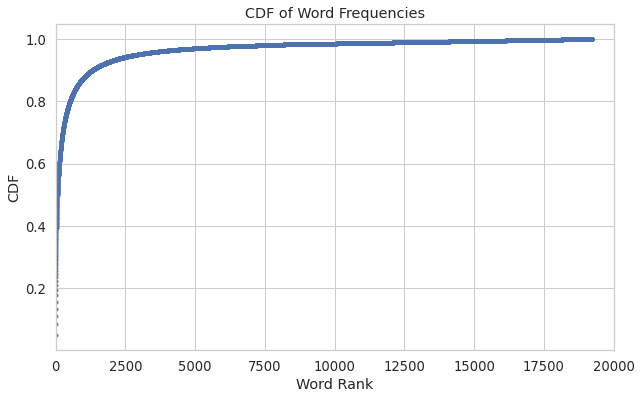

In [36]:
# Convert the word counts to pandas dataframe for visualization
word_counts_ordered_pd = word_counts_ordered.toPandas()

# Compute the cumulative sum of the word frequencies
word_counts_ordered_pd['cumulative_freq'] = word_counts_ordered_pd['count'].cumsum()
word_counts_ordered_pd['cumulative_freq'] /= word_counts_ordered_pd['count'].sum()  # normalizes to get the CDF

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(word_counts_ordered_pd['cumulative_freq'], marker='.', linestyle='none')
plt.xlabel('Word Rank')
plt.xlim(0, 20000)
plt.ylabel('CDF')
plt.title('CDF of Word Frequencies')
plt.grid(True)
plt.show()

In [37]:
# Compute total word occurrences
total_word_occurrences = word_counts_ordered.agg({"count": "sum"}).collect()[0][0]

# Compute occurrences of top N words
N = 15000
top_N_word_occurrences = word_counts_ordered.limit(N).agg({"count": "sum"}).collect()[0][0]

# Compute the coverage
coverage = (top_N_word_occurrences / total_word_occurrences) * 100

print("Total word occurrences:", total_word_occurrences)
print(f"Occurrences of top {N} words:", top_N_word_occurrences)
print(f"Coverage of top {N} words: {coverage:.2f}%")

Total word occurrences: 630099
Occurrences of top 15000 words: 625867
Coverage of top 15000 words: 99.33%


- 20000 words is the number that represents 98.97% in the reviews. Thus, due to memory reasons and performance, the maximum vocabulary will be determined by the train set and them the reviews will be filtered out based on the X number of words. 

In [38]:
# Gets the top N tokens
N = 15000
top_N_tokens = word_counts_ordered.limit(N).select("words").rdd.flatMap(lambda x: x).collect()

# Broadcasting the top tokens list for efficient filtering
top_tokens_broadcast = spark.sparkContext.broadcast(set(top_N_tokens))

# Defines a filtering function that retains only those tokens present in our broadcasted top tokens set
def filter_native(tokens):
    return [t for t in tokens if t in top_tokens_broadcast.value]

# Defining UDF for our function
filter_udf = udf(filter_native, ArrayType(StringType()))

# Apply the UDF to the tokenized column in all three datasets:
df_reviews = df_reviews.withColumn("filtered_tokens", filter_udf(df_reviews["tokens"]))

In [39]:
distinct_token_count = (df_reviews
                        .select(explode(col("filtered_tokens")).alias("word"))
                        .distinct()
                        .count())

print(f"Total distinct tokens in the training set (reviews): {distinct_token_count}")

Total distinct tokens in the training set (reviews): 15000


- Next transformation to be called is to remove the stop words, a step that can be performed in early stages, although on Spark, setences has to be separeted by words. Thus this is why this step is being used now. 

### Removing StopWords

In [40]:
# Defines the stopword remover.
remover = StopWordsRemover(inputCol="filtered_tokens", outputCol="t_no_stopwords")

# Removes stopwords from the training dataset.
df_reviews = remover.transform(df_reviews)

- After some stages of pre processing (mainly transformations) the reviews, it could potentially create empty cells, for example a review with just punctuations or with just stopwords. Therefore, the following code will search for empty reviews in all three datasets. 

In [41]:
# Counts the number of empty reviews.
empty_count = df_reviews.filter(size(df_reviews["t_no_stopwords"]) == 0).count()

# Prints the results.
print(f"Number of empty reviews : {empty_count}")

Number of empty reviews : 1


- The results of the last code shows that all the three sets now have a few empty cells, that might have been transformed to empty due to transformations. Therefore, the chosen option will be to drop the empty ones because it could potentially impact model efficiency.

In [42]:
# Filter out empty reviews in df_reviews
df_reviews = df_reviews.filter(size(df_reviews["t_no_stopwords"]) > 0)

- For computational resources (time consuming), the maximum length of words (the vocabulary) is going to be taken from the train set only, by performing word count and frequency, along with visualization to help identify what is the number that represents the majority (at least 90%) of the words. 

In [43]:
# Counts the number of empty reviews.
empty_count = df_reviews.filter(size(df_reviews["t_no_stopwords"]) == 0).count()

# Prints the results.
print(f"Number of empty reviews : {empty_count}")

Number of empty reviews : 0


The last code shows that there are no more emty reviews.
- Lemmatization will be applied to handle words for example that are in the past, or with ing, but it has the same representation as the verb or noun.

In [44]:
# Loading spaCy model for Lemmatization.
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

# Defines a Pandas UDF to perform lemmatization on a column of tokens.
@pandas_udf(ArrayType(StringType()))
def lemmatize_udf(tokens_series):
    # Functions to lemmatize a list of tokens using spaCy.
    def lemmatize(tokens):
        doc = nlp(" ".join(tokens))
        return [token.lemma_ for token in doc]

    # Appling the lemmatization function to each row in the input column.
    return tokens_series.apply(lemmatize)

# Appling the Pandas UDF to the DataFrame.
df_reviews = df_reviews.withColumn("lemmatized_tokens", lemmatize_udf(df_reviews["t_no_stopwords"]))

- After the stage of processing, the dataset will be split into three different sets, the training, validation and test in order to perform functions without causing any data leakage. 
- The ratio between classes observed a few steps back (i.e: Positives - above 93%), and because of this factor the stratified method will be aplied. When splitting the dataset into three, there is a chance of one of the sets do not get any values for neutral or/and negatives. 

In [45]:
# Defining fractions to split the dataset.
train_fractions = {label: 0.6 for label in df_reviews.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Creating a train set.
df_train = df_reviews.sampleBy("label", fractions=train_fractions, seed=42)

In [46]:
# Creates the 40% left set to be splitted between validation and test.
remaining_df = df_reviews.subtract(df_train)

In [47]:
# Defining fractions to split the dataset.
valid_fractions = {label: 0.5 for label in df_reviews.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Creates the validation set from the 40%, using its franction of 
df_valid = remaining_df.sampleBy("label", fractions=valid_fractions, seed=42)

In [48]:
# Creating test df. 
df_test = remaining_df.subtract(df_valid)

- The division of the set were training have 60%, validation 20% and test 20%. Next, will be performed one-hot-enconder. The model only accepts numbers.

In [49]:
# StringIndexer to convert labels to numerical values
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")

# OneHotEncoder to convert numerical values to one-hot encoded vectors
label_encoder = OneHotEncoder(inputCol="label_index", outputCol="label_encoded")

# Create a pipeline to execute both operations
label_pipeline = Pipeline(stages=[label_indexer, label_encoder])

# Fit and transform the training data
label_model = label_pipeline.fit(df_train)
df_train = label_model.transform(df_train)

In [50]:
# Transform the validation using the same model
df_valid = label_model.transform(df_valid)

In [51]:
# Transform the est data using the same model
df_test = label_model.transform(df_test)

- In this step, will be displayed the maximum length of tokens in order to pad the shorter reviews.

In [52]:
# Creating a funtion.
def vector_length(vector):
    return len(vector)

length_udf = udf(vector_length, IntegerType())

df_train = df_train.withColumn("sequence_length", length_udf(col("lemmatized_tokens")))

In [53]:
max_length = df_train.agg(max(col("sequence_length"))).collect()[0][0]
print(max_length)



187


### 4. Feature Engineering (Word2Vec and Padding)

In this stage feature engineering steps will be applied to the sets.

Word2Vec, the chosen tool, will transform tokens into vectors, with the size of 50 and a minimum count of 5 (it has to pop up at leat 5 times). The model will follow three steps, first will set its configurations, second model will ve trained on the train set, and third will be applied (transform) on all three sets.

In [54]:
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import udf, explode, col
from pyspark.sql.types import ArrayType
from pyspark.ml.linalg import VectorUDT

# 1. Train Word2Vec model
word2Vec = Word2Vec(vectorSize=50, minCount=5, inputCol="lemmatized_tokens", outputCol="temporary_vec")
model = word2Vec.fit(df_train)

# 2. Get the vocabulary and corresponding vectors from the model
vocab_broadcast = spark.sparkContext.broadcast(model.getVectors().rdd.collectAsMap())

# 3. Define a UDF to map each token to its vector
def tokens_to_vectors(tokens):
    vocab = vocab_broadcast.value
    return [vocab[token] for token in tokens if token in vocab]

tokens_to_vectors_udf = udf(tokens_to_vectors, ArrayType(VectorUDT()))

# 4. Transform the DataFrame using the UDF
def transform_dataset(dataset):
    return (dataset
            .withColumn("Review_Vec_Sequence", tokens_to_vectors_udf("lemmatized_tokens"))
            .drop("temporary_vec"))

df_train = transform_dataset(df_train)
df_valid = transform_dataset(df_valid)
df_test = transform_dataset(df_test)


- Next, the padding will be applied so the vectorized tokens can have the same length for the model requirement.

In [55]:
# Define the function to pad (or truncate) sequences
def pad_sequence(tokens, length=187):
    return tokens[:length] + [0] * (length - len(tokens))

# Convert the Python function to a PySpark UDF
pad_sequence_udf = udf(lambda x: pad_sequence(x), ArrayType(IntegerType(), containsNull=False))

In [56]:
# Apply padding to the training dataset
df_train = df_train.withColumn("padded_sequence", pad_sequence_udf(col("Review_Vec_Sequence")))

# Apply padding to the validation dataset
df_valid = df_valid.withColumn("padded_sequence", pad_sequence_udf(col("Review_Vec_Sequence")))

# Apply padding to the test dataset
df_test = df_test.withColumn("padded_sequence", pad_sequence_udf(col("Review_Vec_Sequence")))

Neural Networks, and LSTM is not different required a certain 3-D numpy array shape. Howevever, in the experiment the final step between transforming the data to the right shape did not work and a few approaches were attempted to overcome the issue, but still "error" persisted.
Issues:
Memory problems: The error about memory issues were faced multiple times at different stages of the notebook. At first the issue were appearing at the preprocessing stage where the entire dataset was manipulated and after a few adjustments like reducing by half made the work flows until the transformation from spark dataframe to a numpy. 
However during the last stage many changes and attempts to overcome the problem, which were: 
- Adjusted the dataset ratio using 100%, 50%, 20%, 10%, 1%;
- Revised all the steps to check and correct if any dataframes were being created without purpose, impacting in the memory effiency;
- Also, in the vectorizing stage, different vector sizes were tried, 200, 150, 100, 50. 
- Tried different paths, like changing to pandas and after to numpy format.

After all the attempts, which were many, it was resulting in the same issue, memory. Therefore, due to time constrains the application of the LSTM model was not able to tweaked further to fix the problem. Eventhough the model was not applied, the code was created below, to fit the LSTM model using the training set, with the necessary features for the embedding layer. 

The activation function chosen was the softmax, given the objective which is multi-classification, is the one that provides the probility of the right sentiment. Also, because sentiment analysis tend to overfit the spatial dropout were added to mitigate is risk. The optimizer selected was the adam, mainly because is the "go to" before experiment with other optimizers to check their effiency. And last but not least, following the same rationale as the optimizer, the loss function was the categorical crossentropy, which is the most adequate for the objective.   

In [57]:
#def vector_to_list(v):
 #   return v.toArray().tolist()

#vector_to_list_udf = udf(vector_to_list, ArrayType(FloatType()))

#df_train = df_train.withColumn("padded_sequence", vector_to_list_udf(col("padded_sequence")))

In [58]:
df_train.printSchema()

root
 |-- Rating: integer (nullable = true)
 |-- Review: string (nullable = true)
 |-- label: string (nullable = false)
 |-- Review_lower: string (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- Review_no_punct: string (nullable = true)
 |-- Review_no_punct2: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filt_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- t_no_stopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lemmatized_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- label_index: double (nullable = false)
 |-- label_encoded: vector (nullable = true)
 |-- sequence_length: integer (nullable = true)
 |-- Review_Vec_Sequence: array (nullable = true)
 |    |-- element: vector (containsNull = true)
 |--

In [59]:
# Takes "padded_sequence" column as a list
X_train = df_train.select("padded_sequence").rdd.flatMap(lambda x: x).collect()

# Convert the list to a NumPy array
X_train_np = np.array(padded_sequence_list)


2023-10-11 20:04:37,037 ERROR python.PythonRunner: Python worker exited unexpectedly (crashed)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 599, in main
    eval_type = read_int(infile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:556)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:762)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:744)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:509)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apac

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 102.0 failed 1 times, most recent failure: Lost task 0.0 in stage 102.0 (TID 100) (10.0.2.15 executor driver): net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for pyspark.ml.linalg.DenseVector)
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:773)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:213)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:123)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:136)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$6(BatchEvalPythonExec.scala:94)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.ContextAwareIterator.hasNext(ContextAwareIterator.scala:39)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:86)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:80)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:729)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:435)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2048)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:270)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2450)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2399)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2398)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2398)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1156)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2638)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2580)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2569)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2224)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2245)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2264)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2289)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for pyspark.ml.linalg.DenseVector)
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:773)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:213)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:123)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:136)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$6(BatchEvalPythonExec.scala:94)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.ContextAwareIterator.hasNext(ContextAwareIterator.scala:39)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:86)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:80)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:729)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:435)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2048)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:270)


In [ ]:
df_train =  np.array(df_train.select("padded_sequence").collect())

In [ ]:
# Extracts the "padded_sequence" column as a list of lists.
padded_sequence_list = df_train.select("padded_sequence").rdd.flatMap(lambda x: x[0]).collect()

# Converts the list to a NumPy array.
X_train_np = np.array(padded_sequence_list)


In [ ]:
df_train = df_train.toPandas()

In [ ]:
df_train_pd = df_train.select("padded_sequence", "label_encoded").toPandas()

In [ ]:
#X_train = df_train["padded_sequence"].values

In [ ]:
#y_train = df_train["label_encoded"].values

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# Defining the the model.
model_lstm = Sequential()

# Add an Embedding layer.
embedding_dim = 50  # Setting the same embedding dimension as the Word2Vec model.
vocab_size = 20000   # Vocabulary size, in this was set to be 15000 (max_vocab).
max_length = 195    # Max sequence length.

model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# Adding SpatialDropout1D layer to prevent overfitting.
model_lstm.add(SpatialDropout1D(0.2))  # dropout 20%

# Add an LSTM layer
lstm_units = 128  # Hidden layer with 128 neurons.
model_lstm.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))

# Three output layer (positive, negative and neutral)
num_classes = 3  # Positive, negative and neutrals.
model_lstm.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_lstm.summary()


In [ ]:
# Defining the number of epochs and batch size
epochs = 10  # Epochs, how many times it will run throught the data..
batch_size = 32  

# Train the model on train set.
fitted_lstm = model_lstm.fit(
    X_train,  # Your preprocessed and padded training data
    y_train,        # One-hot encoded training labels
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),  # Validation data
    verbose=2)

# Evaluate the model on your test data
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=2)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Initialize the model.
model_lstm_2 = Sequential()

# Add an Embedding layer.
model_lstm_2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_lstm_2.add(SpatialDropout1D(0.2))

# Add the first LSTM layer.
model_lstm_2.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

# Add more LSTM layers.
model_lstm_2.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_lstm_2.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))

# Adds a dense hidden layer.
model_lstm_2.add(Dense(128, activation='relu'))

# Adds an output layer.
model_lstm_2.add(Dense(3, activation='softmax'))

# Compiles the model.
model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Prints the model summary.
model_lstm_2.summary()